In [224]:
import numpy as np
import matplotlib as plt
from matplotlib.image import imread
import matplotlib.pyplot as p
from scipy.signal import convolve2d
from scipy.signal import fftconvolve
from numpy.random import random
from os import listdir
from time import time
%matplotlib inline

# TODO
- [X] Lave dense layers
- [X] Lave conv layers
- [X] Lave max-pooling
- [ ] cross entropy
- [-] Lave en test model (med test data)
- [ ] Evaluate 🎉
- [ ] Lav den rigtige model
- [ ] webcam blib blob
- [ ] diagram der viser convolution og backprop deraf (samt denselayers) 📌

In [225]:
a = random((200,200))
b = random((10,10))

aa = time()
convolve2d(a,b)
ba = time()
ab = time()
fftconvolve(a,b)
bb = time()

print("normal convolution time: ", (ba-aa)*1000)
print("fft convolution time:    ", (bb-ab)*1000)

normal convolution time:  27.891159057617188
fft convolution time:     3.0095577239990234


In [226]:
image_src = imread("H_test.jpg")

In [227]:
image_src.shape

(200, 200, 3)

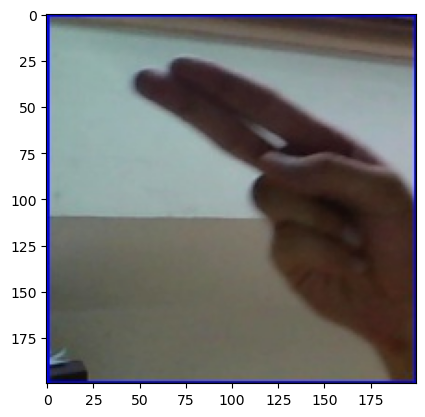

In [228]:
p.imshow(image_src)

In [229]:
def preprocess(image_src):
    image = np.array([n / 255. for n in image_src[:,:,0]]).reshape((200,200))

    # Define the Sobel filter kernels (constant kernels for edge detection)
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Perform convolution with the kernels to get the horizontal and vertical edges
    edges_x = fftconvolve(image, kernel_x, mode='valid')
    edges_y = fftconvolve(image, kernel_y, mode='valid')

    # Combine the horizontal and vertical edges to get the final edge image
    edges = np.sqrt(np.square(edges_x) + np.square(edges_y))

    # Normalize the edge image to a range between 0 and 1
    edges = edges / np.max(edges)
    return image[::3, ::3]

pp_shape = preprocess(image_src).shape
pp_shape

(67, 67)

In [230]:
def rvec(v): # Returns a vector as a single row matrix
    return v.reshape(1, len(v))

def cvec(v): # Returns a vector as a single column matrix
    return v.reshape(len(v), 1)


class DenseLayer:
    def __init__(self, i, o, lr = 0.01):
        self.lr = lr
        self.w = random((o, i)) / i
        self.b = random(o) / i

    def predict(self, i):
        return np.matmul(self.w, i.flatten()) + self.b

    def backprop(self, i, dy):
        i = i.flatten()
        self.w -= np.matmul(cvec(dy), rvec(i)) * self.lr
        self.b -= dy * self.lr
        return np.matmul(self.w.T, dy)

In [231]:
#np.matmul(rvec(np.array([1,2,3])), cvec(np.array([10,100])))

In [232]:
# input -> l1 (CNN) -> l2 (CNN) -> l3 -> cost
# target -> Δcost -> Δl3 -> Δl2 -> Δl1

# x = input matrix
# w = cnn filter
# Δy = gradient

class CNN:
    def __init__(self, filter_shape, lr=0.01):
        self.lr = lr
        self.filter = random(filter_shape)

    def predict(self, i):
        return fftconvolve(i, self.filter, mode='same')
        # mode='same'

    def backprop(self, x, Δy):
        dldf = np.zeros(self.filter.shape)

        for i_row in range(0,self.filter.shape[0]):
            for i_col in range(0,self.filter.shape[1]):

                for k_row in range(0,x.shape[0]):
                    for k_col in range(0,x.shape[1]):

                        drow = k_row + i_row
                        dcol = k_row + i_row

                        if drow >= Δy.shape[0] or dcol >= Δy.shape[1]:
                            continue

                        dldo = Δy[drow, dcol]
                        dodf = x[k_row, k_col]

                        dldf[i_row, i_col] += dldo * dodf

        self.filter -= dldf * self.lr
        return fftconvolve(Δy, self.filter, mode='same')

#def Δ_convolve(w, x, Δy):
#    Δw = convolve2d(w, Δy, mode='valid')
#    Δw = np.zeros_like(w)
#    
#    for i in range(w.shape[0]):
#        for j in range(w.shape[1]):
#            Δw[i,j] = np.sum(Δy[i:i+x.shape[0], j:j+x.shape[1]] * x)

#    w -= Δw
#    return Δw


In [233]:
class MaxPool:
    def __init__(self, shape, scale):
        self.shape = shape
        self.scale = scale

    def predict(self, i):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        s = self.scale
        o = np.zeros((r, c))

        for row in range(0, r):
            for col in range(0, c):
                i_ = i[row*s:row*s+s, col*s:col*s+s]

                o[row,col] = i_.max()
        return o
    
    def backprop(self, i, dy):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        s = self.scale
        o = np.zeros(self.shape)
        dy = dy.reshape((r,c))

        #for row in range(0,self.shape[0]):
        #    for col in range(0,self.shape[1]):
        #        o[row, col] = dy[int(row/self.scale), int(col/self.scale)]

        #for row in range(0,r):
        #    for col in range(0,c):
        #        o[row*self.scale, col*self.scale] = dy[row, col]

        for row in range(0, r):
            for col in range(0, c):
                i_ = i[row*s:row*s+s, col*s:col*s+s]
                m = i_.argmax()
                o[m] = dy[row, col]
        return o

In [234]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum()

def delta_softmax(x, grad):
    return softmax(x) * (1 - softmax(x)) * grad

In [235]:
train_path = "asl_alphabet_train/asl_alphabet_train/"
test_path = "asl_alphabet_test/asl_alphabet_test/"

# Load training data from `train_path`
train_data = {}
for letter in listdir(train_path):
    path = train_path+letter+"/"
    train_data[letter] = [path+f for f in listdir(path)]

In [236]:
train_data.keys()

dict_keys(['G', 'U', 'R', 'J', 'K', 'W', 'H', 'M', 'space', 'B', 'Z', 'E', 'O', 'I', 'nothing', 'Q', 'F', 'V', 'P', 'Y', 'T', 'N', 'del', 'L', 'D', 'C', 'A', 'X', 'S'])

In [237]:
labels = {}
i = 0
for n in train_data.keys():
    labels[n]=i
    i+=1

len(labels)

29

In [238]:
def onehot(n, len):
    o = np.zeros(len)
    o[n] = 1
    return 0

In [254]:
filters = 4
l1 = [CNN((10, 10), lr=0.01) for n in range(filters)]
l2 = MaxPool((pp_shape[0]+1, pp_shape[1] * filters + 1), 4)
l3 = DenseLayer(int(((pp_shape[0] * filters+1)/4)**2), len(labels), lr=0.01)

In [255]:
def training_data(i):
    return [
        (
            preprocess(imread(train_data[letter][i])),
            onehot(labels[letter], len(labels)),
            letter
        ) for letter in train_data.keys()
    ]

In [256]:
i = 0
correct = 0

for n in range(0,10):
    for (img, target, letter) in training_data(n):
        s = img.shape

        l1o = np.array([l1.predict(img) for l1 in l1])
        #l1o = l1.predict(img)
        l1o = l1o.reshape((s[0], s[1]*filters))

        l2o = l2.predict(l1o)
        l2o = np.tanh(l2o)

        l3o = l3.predict(l2o.flatten())
        out = softmax(l3o)

        if labels[letter] == out.argmax():
            correct += 1
        
        dc = 2*(out - target)
        d3 = l3.backprop(l2o, delta_softmax(l3o, dc))
        d3 = (-np.tanh(l2o)**2 + 1).flatten() * d3
        d2 = l2.backprop(l1o, d3)
        #l1.backprop(img, d2)
        for f in range(filters):
            l1[f].backprop(img, d2[:,s[1]*f:s[1]*f+f])

        i += 1
        print(n,"accuracy: ", correct/i*100, "% out:", out.argmax())

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1139 is different from 4522)

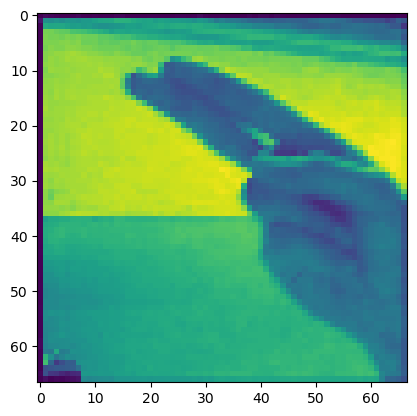

In [ ]:
#p.imshow(imread("H_test.jpg")[::3,::3][:,:,0])

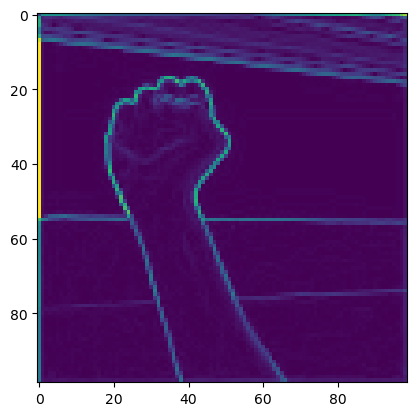

In [ ]:
#p.imshow(img)

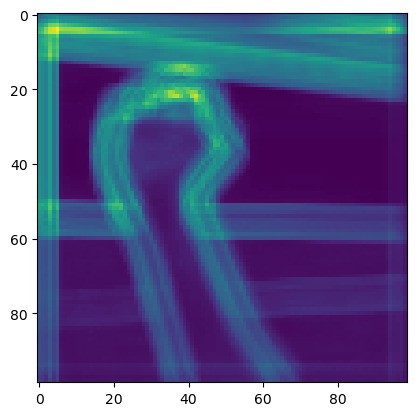

In [ ]:
#o1 = l1.predict(img)
#p.imshow(o1)

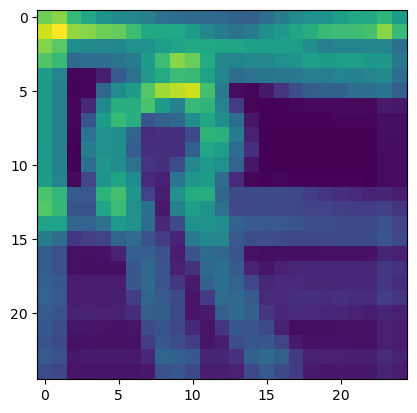

In [ ]:
#o2 = l2.predict(o1)
#p.imshow(o2)

In [ ]:
   [[2,3,4],
    [4,5,6]] ** 2


array([[32, 41, 50, 59],
       [50, 65, 80, 95]])